Copyright 2019 The Google Research Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
num_layers = 13
num_sentences = 2000

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Install and import Huggingface Transformer models
!pip install transformers ftfy spacy
from transformers import *

     |████████████████████████████████| 450kB 3.4MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 1.0MB 41.5MB/s 
     |████████████████████████████████| 870kB 48.2MB/s 
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44553 sha256=c3af4fed2202462cdc0cbfa6fa6cc88de4708a6a27eddc287251406fa094e33b
  Stored in directory: /root/.cache/pip/wheels/43/34/ce/cbb38d71543c408de56f3c5e26ce8ba495a0fa5a28eaaf1046
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=ff893f853d92c269071d9e0b8b5baa31c48515c4ccd141411163de922e46c89c
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built ftfy sacremoses


In [0]:
def get_model(model_id):
  print('Loading model: ', model_id)

  models = {
    'gpt2': (GPT2Model, GPT2Tokenizer, 'gpt2'),
    'gpt2-medium': (GPT2Model, GPT2Tokenizer, 'gpt2-medium'),
    'gpt2-large': (GPT2Model, GPT2Tokenizer, 'gpt2-large'),
    'gpt2-xl': (GPT2Model, GPT2Tokenizer, 'gpt2-xl'),
  }

  model_class, tokenizer_class, pretrained_weights = models[model_id]
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights, output_hidden_states=True, cache_dir=cache_dir)

  def text2features(text):
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    with torch.no_grad():
        hidden_states = model(input_ids=input_ids)
    return hidden_states

  return text2features

# Compute model activations of data for an architecture.
# Returns a 2D numpy array with [n_datapoints, n_features].
# Each word is one datapoint, and converts to one feature vector.
def get_activations(f_model, data, num_layers=num_layers):
  print('Computing activations...')
  h = []
  for i in tqdm(range(len(data))):
    _data = data[i]
    hiddens = f_model(_data)[2] # Get all hidden layers
    hiddens = [h.numpy() for h in hiddens]
    hiddens = np.concatenate(hiddens, axis=0)
    hiddens = hiddens[-num_layers:]
    # hiddens.shape = (num_layers, num_datapoints, num_features)
    h.append(hiddens)
  h = np.concatenate(h, axis=1)
  print('Activations shape: ', h.shape)
  return h

# Load data: a subset of the Penn Treebank dataset.
# Returns a list of strings
def get_data():
  import pandas as pd
  data = pd.read_json('https://raw.githubusercontent.com/nlp-compromise/penn-treebank/f96fffb8e78a9cc924240c27b25fb1dcd8974ebf/penn-data.json')
  data = data[0].tolist() # First element contains raw text
  return data

def compute_and_save_activations(data, model_id):
  # Get models
  f_model = get_model(model_id)
  # Compute activations for model
  h = get_activations(f_model, data)
  # Save to drive
  path = data_folder+'h_'+model_id+'.npy'
  print("Saving to path:", path)
  np.save(path, h)
  
def load_activations(model_id):
  print("Loading activations from disk...")
  x = np.load(data_folder+'h_'+model_id+'.npy')
  return x

def compute_svd(x, normalize=True):
  print("Normalizing and computing SVD...")
  results = []
  for i in range(x.shape[0]):
    print(i)
    _x = x[i]
    if normalize:
      _x -= _x.mean(axis=0, keepdims=True)
      _x /= _x.std(axis=0, keepdims=True)
    _x = np.linalg.svd(_x, full_matrices=False)[0]
    results.append(_x)
  x = np.stack(results)
  return x

def save_svd(model_id, x):
  np.save(data_folder+'svd_'+model_id+'.npy', x)

def load_svd(model_id):
  return np.load(data_folder+'svd_'+model_id+'.npy')

def compute_and_save_svd(model_id):
  x = load_activations(model_id)
  x = x[-num_layers:]
  print(x.shape)
  h = compute_svd(x)
  save_svd(model_id, h)

def get_cca_similarity_fast(x, y, i1, i2, k=None):
  """Performs singular vector CCA on two matrices.

  Args:
    X: numpy matrix, activations from first network (num_samples x num_units1).
    Y: numpy matrix, activations from second network (num_samples x num_units2).
    k: int or None, number of components to keep before doing CCA (optional:
        default=None, which means all components are kept).

  Returns:
    corr_coeff: numpy vector, canonical correlation coefficients.

  Reference:
    Raghu M, Gilmer J, Yosinski J, Sohl-Dickstein J. "SVCCA: Singular Vector
    Canonical Correlation Analysis for Deep Learning Dynamics and
    Interpretability." NIPS 2017.
  """
  return np.linalg.svd(np.dot(x[i1, :, :k].T, y[i2, :, :k]), compute_uv=False)

def compute_correlations(x, y, ks):
  num_layers = min(x.shape[0], y.shape[0])
  results = {}
  for k in ks:
    # Calculate all correlation coefficients
    rs = np.asarray([get_cca_similarity_fast(x, y, i, i, k) for i in range(-num_layers, 0)])
    results[k] = rs
  return results

def plot_correlations(results):
  i = 1
  plt.figure(figsize=[len(results)*5,4])
  for k in results:
    plt.subplot(1,len(results),i)
    plt.ylim(0, 1)
    plt.xlabel('CCA coefficient index')
    plt.ylabel('$r$ (correlation coefficient)')
    for j in [0,3,6,9,12]:
      label = "last"
      if j < 12: label += " - "+str(12-j)
      plt.plot(results[k][j], label=label)
    plt.title(str(k)+' principal components')
    plt.legend()
    i += 1


# Compute and save activations


In [0]:
# Get data
all_data = get_data()
print(len(all_data))
data = all_data[:num_sentences]

# Compute and save activations 
compute_and_save_activations(data, 'gpt2')
compute_and_save_activations(data, 'gpt2-medium')
compute_and_save_activations(data, 'gpt2-large')
compute_and_save_activations(data, 'gpt2-xl')

3914
Loading model:  gpt2


  0%|          | 0/2000 [00:00<?, ?it/s]

Computing activations...


100%|██████████| 2000/2000 [04:27<00:00,  8.22it/s]


Activations shape:  (13, 55034, 768)
Saving to path: /content/gdrive/My Drive/2020-01_IdentifiableSelfSup/data/h_gpt2.npy
Loading model:  gpt2-medium


  0%|          | 0/2000 [00:00<?, ?it/s]

Computing activations...


100%|██████████| 2000/2000 [14:01<00:00,  2.80it/s]


Activations shape:  (13, 55034, 1024)
Saving to path: /content/gdrive/My Drive/2020-01_IdentifiableSelfSup/data/h_gpt2-medium.npy


# Compute and save SVD

In [0]:
compute_and_save_svd('gpt2')
compute_and_save_svd('gpt2-medium')
compute_and_save_svd('gpt2-large')
compute_and_save_svd('gpt2-xl')

Loading activations from disk...
(13, 55034, 768)
Normalizing and computing SVD...
0
1
2
3
4
5
6
7
8
9
10
11
12
Loading activations from disk...
(13, 55034, 1024)
Normalizing and computing SVD...
0
1
2
3
4
5
6
7
8
9
10
11
12


# Compute all pairwise correlations

In [0]:
# Load SVDs

x_small = load_svd('gpt2')
x_medium = load_svd('gpt2-medium')
x_large = load_svd('gpt2-large')
x_xl = load_svd('gpt2-xl')

In [0]:
ks = [16,64,256,768] # Layers to compute correlations over
r_s_m = compute_correlations(x_small, x_medium, ks)
r_m_l = compute_correlations(x_medium, x_large, ks)
r_l_xl = compute_correlations(x_large, x_xl, ks)
r_s_xl = compute_correlations(x_small, x_xl, ks)
r_m_xl = compute_correlations(x_medium, x_xl, ks)
r_s_xl = compute_correlations(x_small, x_large, ks)
results = [r_s_m, r_m_l, r_l_xl, r_s_xl, r_m_xl, r_s_xl]

In [0]:
def get_mean_results(results, k):
  x = np.asarray([result[k] for result in results])
  x = np.mean(x, axis=0)
  return x[::-1]

r_16 = get_mean_results(results, 16)[0::4]
r_64 = get_mean_results(results, 64)[0::4]
r_256 = get_mean_results(results, 256)[0::4]
r_768 = get_mean_results(results, 768)[0::4]
rs = {16: r_16, 64: r_64, 256: r_256, 768: r_768}

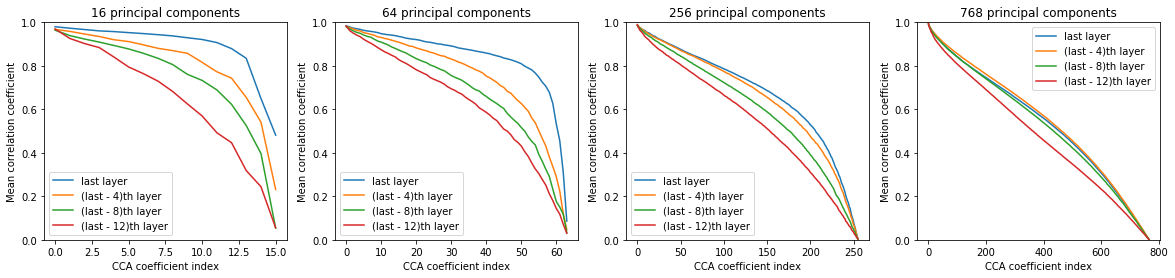

In [0]:
i = 1
plt.figure(figsize=[len(rs)*5,4])
for k in rs:
  plt.subplot(1,len(rs),i)
  plt.ylim(0, 1)
  plt.xlabel('CCA coefficient index')
  plt.ylabel('Mean correlation coefficient')
  for j in range(len(rs[k])):
    if j == 0: label = "last layer"
    if j > 0: label = "(last - "+str(4*j)+")th layer"
    plt.plot(rs[k][j], label=label)
  plt.title(str(k)+' principal components')
  plt.legend()
  i += 1
plt.savefig(root_folder+"fig_layers.pdf")